In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2/Training.csv',delimiter=',',skip_header=True)

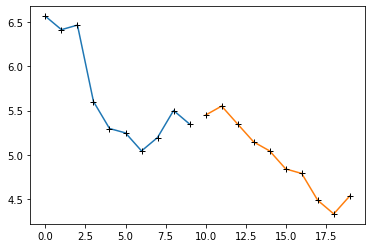

In [5]:
# Defining split sizes 

test_size = 1152
train_size = len(X) - test_size

train_raw = X[:train_size]
test_raw = X[train_size:]

train_raw.shape, test_raw.shape

plt.plot(figsize=(20,5))
plt.plot(range(10),train_raw[-10:,0])
plt.plot(range(10,20),test_raw[:10,0])
plt.plot(range(0,20),X[train_size-10:train_size+10,0],'+k')

In [6]:
# Pre-processing

train_max = train_raw.max(axis=0)
train_min = train_raw.min(axis=0)

X_mean = train_raw.mean(axis=0)
X_std = train_raw.std(axis=0)

train_scaled = (train_raw-train_min)/(train_max-train_min)
test_scaled = (test_raw-train_min)/(train_max-train_min)

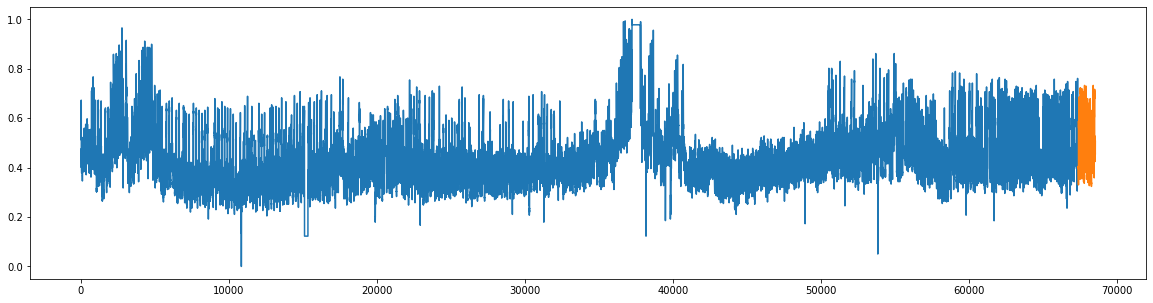

In [7]:
i=0
plt.figure(figsize=(20,5))
plt.plot(train_scaled[:,i])
plt.plot(range(train_size, train_size+test_size),test_scaled[:,i])

In [8]:
# generate X, y
def extract_sequences(array,sequence_length = 200,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [9]:
def build_lstm(input_shape,n_units):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(units=n_units, return_sequences=False,return_state=False)(input_layer)
    x = tfkl.Flatten()(x)
    
    output_layer = tfkl.Dense(7,bias_initializer=tfk.initializers.Constant(train_scaled.mean(axis=0)))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [10]:
def build_gru(input_shape,n_units):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.GRU(units=n_units, return_sequences=False,return_state=False)(input_layer)
    x = tfkl.Flatten()(x)
    
    output_layer = tfkl.Dense(7,bias_initializer=tfk.initializers.Constant(train_scaled.mean(axis=0)))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [11]:
models_array = []
history_array = []

epochs = 200
batch_size = 256

stride = 1
sequence_length = 400
X_train, y_train = extract_sequences(train_scaled,sequence_length,stride)
X_train.shape,y_train.shape
    
input_shape = X_train.shape[1:]

units = 352

models = [build_lstm,build_gru]
models_lables = ['base lstm','base gru']

for m in models:

    model = m(input_shape,units)
    model.summary()

    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

    history = model.fit(
        X_train,
        y_train,
        validation_split=.1,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
        ]
    ).history
    
    models_array.append(model)
    history_array.append(history)

2022-01-15 11:07:06.462126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 11:07:06.549500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 11:07:06.550209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 11:07:06.551269: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 352)               506880    
_________________________________________________________________
flatten (Flatten)            (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 2471      
Total params: 509,351
Trainable params: 509,351
Non-trainable params: 0
_________________________________________________________________


2022-01-15 11:07:10.382440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-15 11:07:12.781437: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


236/236 [==============================] - 25s 93ms/step - loss: 0.0033 - mae: 0.0386 - val_loss: 0.0014 - val_mae: 0.0253
Epoch 2/200
236/236 [==============================] - 21s 90ms/step - loss: 0.0012 - mae: 0.0233 - val_loss: 0.0011 - val_mae: 0.0216
Epoch 3/200
236/236 [==============================] - 21s 91ms/step - loss: 9.9346e-04 - mae: 0.0210 - val_loss: 0.0011 - val_mae: 0.0218
Epoch 4/200
236/236 [==============================] - 21s 90ms/step - loss: 9.0748e-04 - mae: 0.0197 - val_loss: 9.3384e-04 - val_mae: 0.0200
Epoch 5/200
236/236 [==============================] - 21s 90ms/step - loss: 8.7386e-04 - mae: 0.0192 - val_loss: 9.1063e-04 - val_mae: 0.0200
Epoch 6/200
236/236 [==============================] - 21s 90ms/step - loss: 8.5536e-04 - mae: 0.0190 - val_loss: 8.5469e-04 - val_mae: 0.0185
Epoch 7/200
236/236 [==============================] - 21s 90ms/step - loss: 8.3266e-04 - mae: 0.0185 - val_loss: 8.6653e-04 - val_mae: 0.0189
Epoch 8/200
236/236 [==========

In [12]:
future_window = 1152

In [13]:
def autoregression_pred(model,window):
    last_window = train_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape

    pred = np.array([])
    X_temp = last_window
    for t in range(future_window):
        pred_temp = model.predict(X_temp)
        pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)
        
    pred_scaled = pred[0]*(train_max-train_min)+train_min
    return pred_scaled    

In [14]:
def compute_err(pred_scaled,return_values=True):
    rmse = np.sqrt(tfk.metrics.mse(test_raw[:future_window].flatten(),pred_scaled.flatten()))
    mae = (tfk.metrics.mae(test_raw[:future_window].flatten(),pred_scaled.flatten())).numpy()
    print("RMSE: " + str(rmse) + "  MAE: " + str(mae))
    if(return_values):
        return rmse,mae

In [15]:
pred_array = []
for i,model in enumerate(models_array):
    pred_array.append(autoregression_pred(model,sequence_length))

In [16]:
best_rmse = 1e7
best_model = 0

for i,pred in enumerate(pred_array):
    rmse,mae = compute_err(pred)
    if(rmse < best_rmse):
        best_rmse = rmse
        best_model = i
        
print("\nBest model is " + str(models_lables[best_model]))

RMSE: 5.2603725286642495  MAE: 3.761929086847687
RMSE: 6.9692622845735  MAE: 4.720572183303563

Best model is base lstm


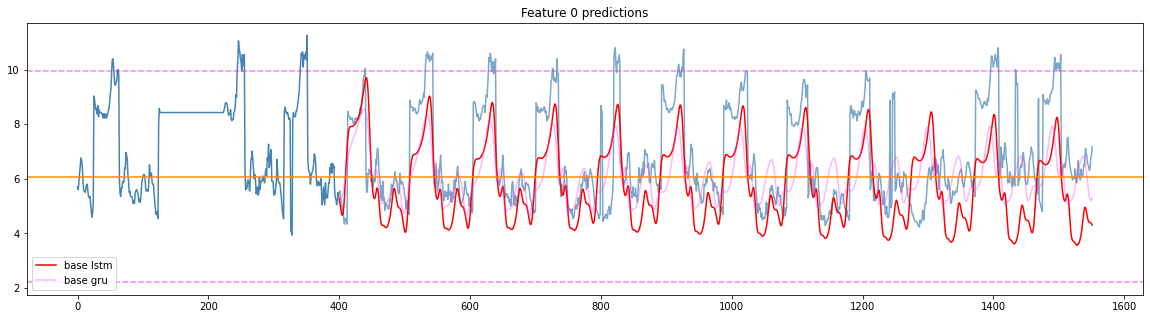

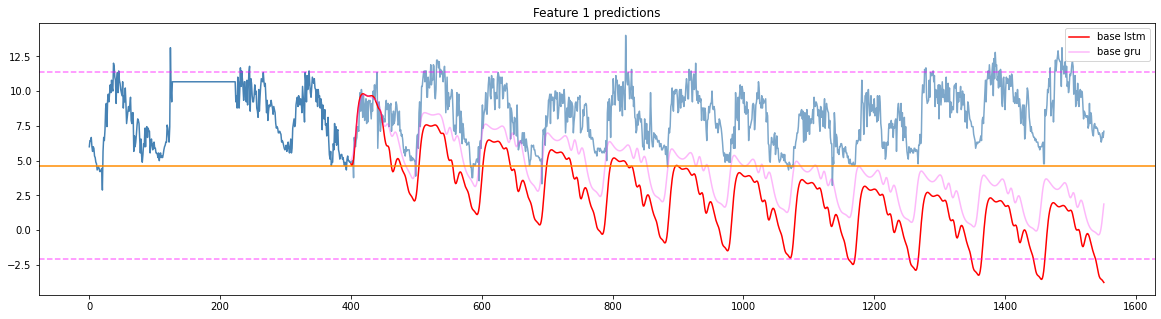

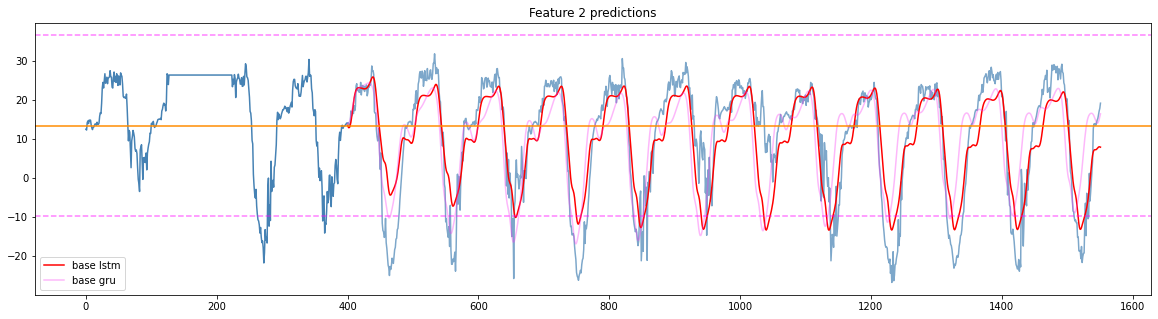

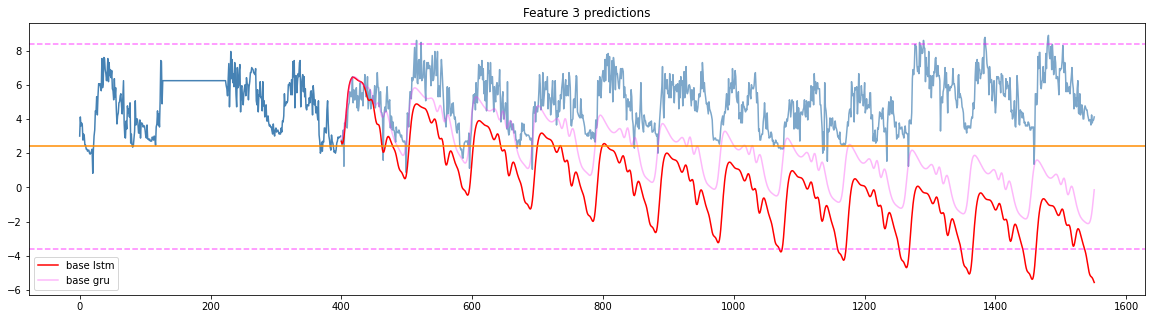

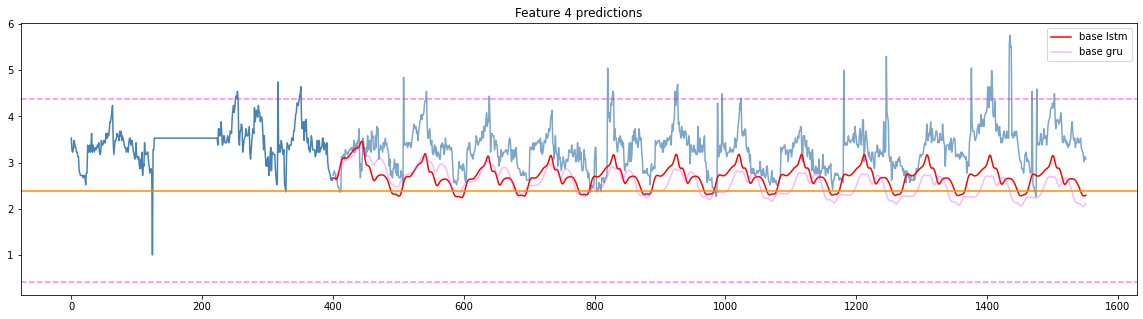

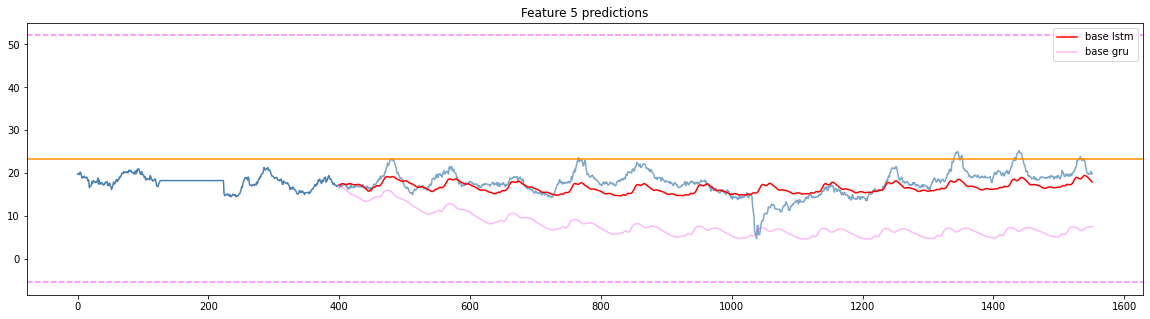

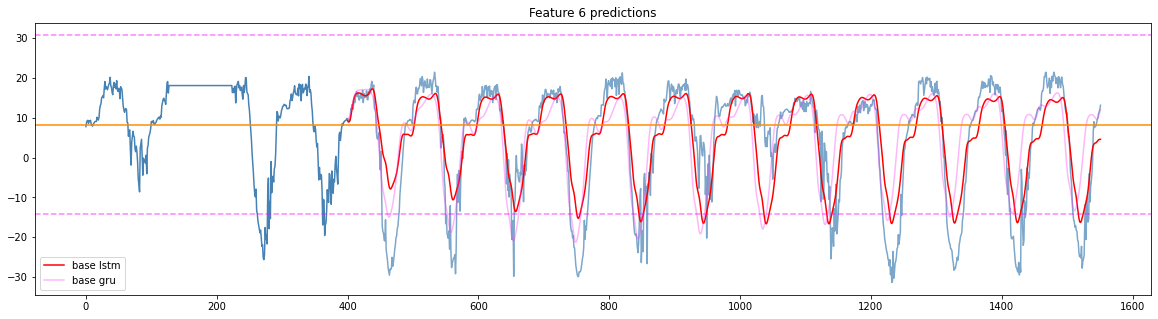

In [17]:
colors = ['#7d34fa','#fa34f3','#032cfc','#ff006f','#00ffd5','#62ff57']
window = sequence_length
for i in range(7):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),train_raw[-window:,i],color="steelblue")
    plt.plot(range(window,window+future_window),test_raw[:future_window,i],color="steelblue",alpha=.7)
    for j,pred in enumerate(pred_array):
        if(j!=best_model): 
            alpha_val = 0.35
            c = colors[j]
        else: 
            alpha_val = 1
            c = '#ff0000'
        plt.plot(range(window,window+future_window),pred[:,i],label=models_lables[j],alpha=alpha_val,color=c)
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.title('Feature ' + str(i) + ' predictions')
    plt.legend()


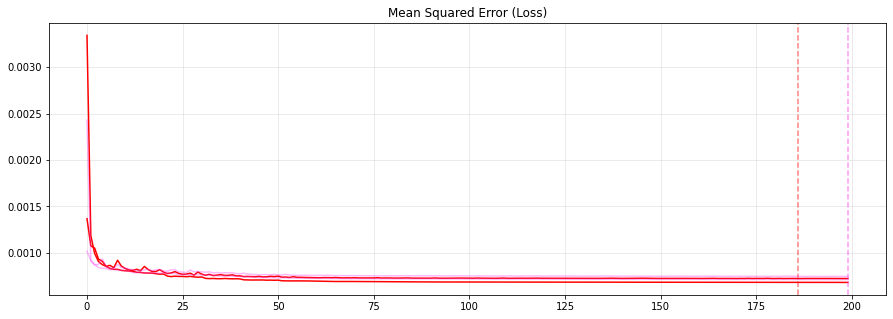

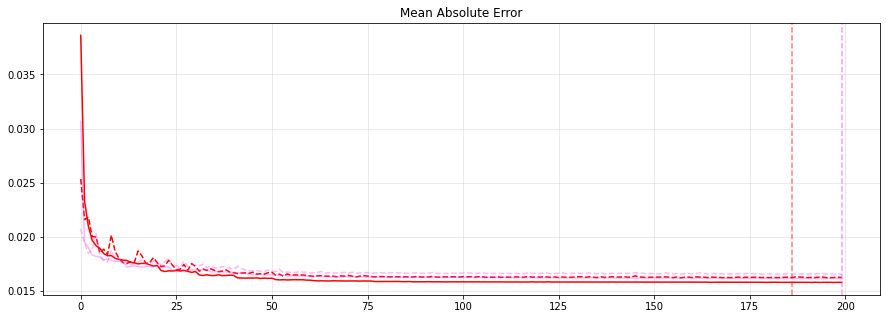

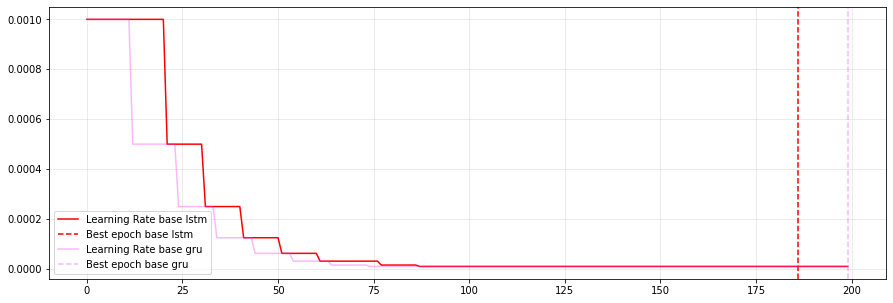

In [18]:
fig_size = (15,5)
plt.figure(figsize=fig_size)


for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['loss'], label='Training loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_loss'], label='Validation loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch ' + models_lables[i], alpha=.5, ls='--',color=c)

plt.title('Mean Squared Error (Loss)')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)

for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['mae'], label='Training accuracy '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_mae'], label='Validation accuracy '+ models_lables[i],alpha=alpha_val,ls='--',color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=.5, ls='--',color=c)
    
plt.title('Mean Absolute Error')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['lr'], label='Learning Rate '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=alpha_val, ls='--',color=c)

plt.legend()
plt.grid(alpha=.3)
plt.show()

In [19]:
import shutil
from os import path
def save_model(model,filename):
    model.save(filename)
    src = path.realpath(filename)
    root_dir, tail = path.split(src)
    shutil.make_archive(filename, 'zip', filename)
    print(filename + ' saved!')

In [20]:
for i,model in enumerate(models_array):
    save_model(model,models_lables[i])
#save_model(model_2,'model_2')

2022-01-15 13:30:29.526396: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


base lstm saved!
base gru saved!


In [21]:
#!rm -r model model.zip model_1 model_1.zip model_2 model_2.zip
#!zip -r model.zip model
#model = tfk.models.load_model('model')